In [1]:
from tqdm import tqdm
import random
import sys
sys.path.append("../")
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from cachingalgo.full_observation.single_cache import LFU, LFULite, WLFU, CountSketch
from cachingalgo.request_generation.continuous import szipf, dzipf, youtube

## Simulation of LFU, LFULite and WLFU

### Regret and Counter Analysis

In [2]:
def reg_count(L, cache_size, optcache, req, algo, stepreq=None):
    """
    Calculates the regret and counters used at each time step 
    L: Library size
    cache_size: Size of the Cache
    optcache: Optimal Cache of length equal to cache_size
    algo: 'lfu' or 'wlfu' or 'lfuite'
    stepreq: None - using data other than dynamic zipf data
    req: Requests
    Returns Regret, Counter Used at each time step and final cache
    """
    reg = 0
    if algo != 'wlfu':
        counters = np.zeros((req.shape[0],))
    regret = np.zeros((req.shape[0],))
    
    if algo == 'lfu':
        alg = LFU(L=L, cache_size=cache_size)
    elif algo == 'wlfu':
        alg = WLFU(L=L, cache_size=cache_size)
    elif algo == 'lfulite':
        alg = LFULite(L=L, cache_size=cache_size)
    else:
        raise ValueError("arguments for algo should be 'lfu' or 'lfulite' or 'wlfu'")
        
    currcache = random.sample(range(1,L), cache_size)
    optimcache = optcache

    for i in tqdm(range(req.shape[0])):
        request = req[i]
        
        if stepreq != None:
            rem = i // stepreq
            optimcache = optcache[rem*cache_size:(rem+1)*cache_size]
            
        
        lhs = 1 if request in optimcache else 0
        rhs = 1 if request in currcache else 0
        
        if algo == 'lfulite':
            alg.update(request, i)
            currcache = alg.currcache(i)
        else:
            alg.update(request)
            currcache = alg.currcache()

        reg += (lhs-rhs)
        regret[i] = reg
        
        if algo != 'wlfu':
            counters[i] = alg.counters_used()
        
    if algo == 'wlfu': 
        return {'regret':regret}
    else:
        return {'regret':regret, 'counters':counters}

In [3]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data
dzdata = dzipf(count=50_000, a=1, L=1_61_085, req_step=5_000, window=500, top=50, cache_size=10) # Dynamic Zipf Data
ytdata = youtube(count=50_000) # YouTube Data

# Defining Parameters
cache_size = 10
L = szdata['prob'].shape[0]

# assigning Optimal caches for regret calculation
optcache_sz = np.argsort(szdata['prob'])[::-1][:cache_size]
optcache_yt = np.argsort(ytdata['prob'])[::-1][:cache_size]
optcache_dz = dzdata['optim_cache']

LFU_sz = reg_count(L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'], algo='lfu')
LFU_dz = reg_count(L=L, cache_size=cache_size, optcache=optcache_dz, req=dzdata['req'], algo='lfu', stepreq=5000)
LFU_yt = reg_count(L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'], algo='lfu')

WLFU_sz = reg_count(L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'], algo='wlfu')
WLFU_dz = reg_count(L=L, cache_size=cache_size, optcache=optcache_dz, req=dzdata['req'], algo='wlfu', stepreq=5000)
WLFU_yt = reg_count(L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'], algo='wlfu')

LFULite_sz = reg_count(L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'], algo='lfulite')
LFULite_dz = reg_count(L=L, cache_size=cache_size, optcache=optcache_dz, req=dzdata['req'], algo='lfulite', stepreq=5000)
LFULite_yt = reg_count(L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'], algo='lfulite')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2612.63it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


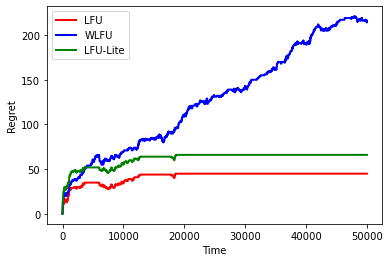

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


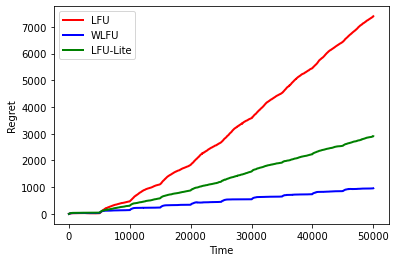

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


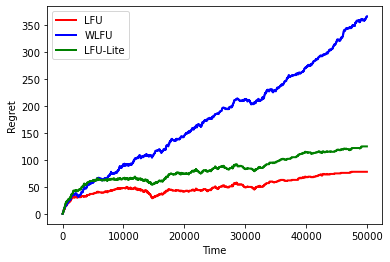

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


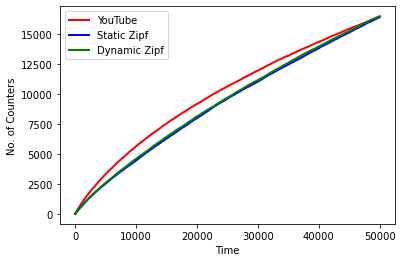

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


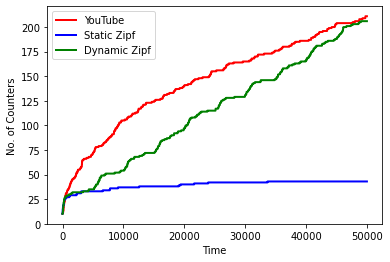

In [4]:
x = [i for i in range(szdata['req'].shape[0])]

# Static Zipf
plt.plot(x, LFU_sz['regret'], 'r', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_sz['regret'], 'b',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_sz['regret'], 'g',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/szallr.eps')
plt.show()

# Dynamic Zipf
plt.plot(x, LFU_dz['regret'], 'r', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_dz['regret'], 'b',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_dz['regret'], 'g',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/dzallr.eps')
plt.show()

# YouTube Data
plt.plot(x, LFU_yt['regret'], 'r', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_yt['regret'], 'b',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_yt['regret'], 'g',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/ytallr.eps')
plt.show()

# LFU

plt.plot(x, LFU_yt['counters'], 'r', label = 'YouTube', linewidth=2)
plt.plot(x, LFU_sz['counters'], 'b',label = 'Static Zipf', linewidth=2)
plt.plot(x, LFU_dz['counters'], 'g',label = 'Dynamic Zipf', linewidth=2)

plt.xlabel("Time")
plt.ylabel("No. of Counters")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/LFUc.eps')
plt.show()


# LFU

plt.plot(x, LFULite_yt['counters'], 'r', label = 'YouTube', linewidth=2)
plt.plot(x, LFULite_sz['counters'], 'b',label = 'Static Zipf', linewidth=2)
plt.plot(x, LFULite_dz['counters'], 'g',label = 'Dynamic Zipf', linewidth=2)

plt.xlabel("Time")
plt.ylabel("No. of Counters")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/LFULitec.eps')
plt.show()

### Hit Rate Analysis

In [6]:
def hit_rate(L, cache, req, algo):
    """
    Calculates the hit rate for varying cache size
    L: Library size
    cache: vector of different cache size
    algo: 'lfu' or 'wlfu' or 'lfuite'
    req: Requests
    Returns hitrate 
    """
    hitrate = np.zeros(len(cache),)
    for itr, cache_size in tqdm(enumerate(cache)):
    
        if algo == 'lfu':
            alg = LFU(L=L, cache_size=cache_size)
        elif algo == 'wlfu':
            alg = WLFU(L=L, cache_size=cache_size)
        elif algo == 'lfulite':
            alg = LFULite(L=L, cache_size=cache_size)
        else:
            raise ValueError("arguments for algo should be 'lfu' or 'lfulite' or 'wlfu'")

        currcache = random.sample(range(1,L), cache_size)
        hits = 0

        for i in range(req.shape[0]):
            request = req[i]

            if request in currcache:
                hits+=1

            if algo == 'lfulite':
                alg.update(request, i)
                currcache = alg.currcache(i)
            else:
                alg.update(request)
                currcache = alg.currcache()
        hitrate[itr] = hits
        
    return hitrate/req.shape[0]


In [7]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data
dzdata = dzipf(count=50_000, a=1, L=1_61_085, req_step=5_000, window=500, top=50, cache_size=10) # Dynamic Zipf Data
ytdata = youtube(count=50_000) # YouTube Data

# Defining Parameters
cache = [5, 10, 15, 20, 25]
L = szdata['prob'].shape[0]

LFU_sz_hit = hit_rate(L=L, cache=cache, req=szdata['req'], algo='lfu')
LFU_dz_hit = hit_rate(L=L, cache=cache, req=dzdata['req'], algo='lfu')
LFU_yt_hit = hit_rate(L=L, cache=cache, req=ytdata['req'], algo='lfu')

WLFU_sz_hit = hit_rate(L=L, cache=cache, req=szdata['req'], algo='wlfu')
WLFU_dz_hit = hit_rate(L=L, cache=cache, req=dzdata['req'], algo='wlfu')
WLFU_yt_hit = hit_rate(L=L, cache=cache, req=ytdata['req'], algo='wlfu')

LFULite_sz_hit = hit_rate(L=L, cache=cache, req=szdata['req'], algo='lfulite')
LFULite_dz_hit = hit_rate(L=L, cache=cache, req=dzdata['req'], algo='lfulite')
LFULite_yt_hit = hit_rate(L=L, cache=cache, req=ytdata['req'], algo='lfulite')

5it [22:23, 268.80s/it]
5it [23:24, 280.84s/it]
5it [23:57, 287.46s/it]
5it [01:36, 19.38s/it]
5it [01:38, 19.63s/it]
5it [02:12, 26.53s/it]
5it [01:54, 22.86s/it]
5it [02:14, 26.93s/it]
5it [03:13, 38.70s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


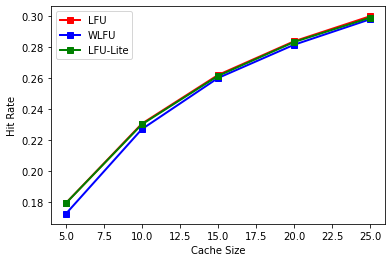

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


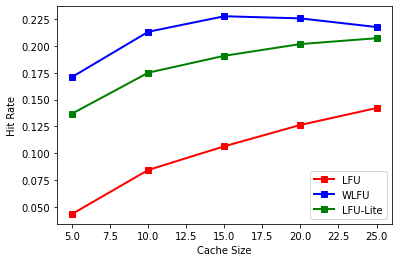

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


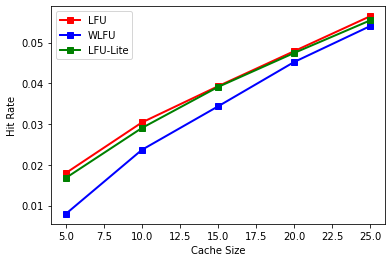

In [10]:
x = cache

# Static Zipf
plt.plot(x, LFU_sz_hit, '-rs', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_sz_hit, '-bs',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_sz_hit, '-gs',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Cache Size")
plt.ylabel("Hit Rate")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/szallhit.eps')
plt.show()

# Dynamic Zipf
plt.plot(x, LFU_dz_hit, '-rs', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_dz_hit, '-bs',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_dz_hit, '-gs',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Cache Size")
plt.ylabel("Hit Rate")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/dzallhit.eps')
plt.show()

# YouTube
plt.plot(x, LFU_yt_hit, '-rs', label = 'LFU', linewidth=2)
plt.plot(x, WLFU_yt_hit, '-bs',label = 'WLFU', linewidth=2)
plt.plot(x, LFULite_yt_hit, '-gs',label = 'LFU-Lite', linewidth=2)

plt.xlabel("Cache Size")
plt.ylabel("Hit Rate")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/ytallhit.eps')
plt.show()


### Batch Analysis of LFULite

In [2]:
def lfulite_batch(L, cache_size, optcache, req, batch, name=''):
    """
    Calculates and plots the regret, no. of counters and hit rate while changing batch size 
    L: Library size
    cache_size: Size of the Cache
    optcache: Optimal Cache of length equal to cache_size
    req: Requests
    batch: Batch Size for the update of the algorithm
    name: Name of the plots
    Returns plots of regret and no. of counters, and hit rate
    """
    Hit_rate = np.zeros(len(batch),)
    reqshape = req.shape[0]

    x = [i for i in range(reqshape)]
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    for itr, j in enumerate(tqdm(batch)):
        #Metrics Initialisation
        reg = 0
        regret = np.zeros((reqshape,))
        counters = np.zeros((reqshape,))
        hits = 0

        #Algorithm Initialisation
        alg = LFULite(L=L, cache_size=cache_size)
        currcache = random.sample(range(1,L), cache_size)
        for i in range(reqshape):
            request = req[i]    

            lhs = 1 if request in optcache else 0

            if request in currcache:
                rhs = 1
                hits += 1
            else:
                rhs = 0

            alg.wlfu.update(request)
            if (i+1) % j == 0:
                alg.update(request, i, wlfu=False)
                currcache = alg.currcache(i)

            reg += (lhs-rhs)
            regret[i] = reg
            counters[i] = alg.counters_used()
        Hit_rate[itr] = (hits/reqshape)


        ax1.plot(x,list(regret), label = f'Batch = {j}', linewidth=2)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Regret')

        ax2.plot(x,list(counters), label = f'Batch = {j}', linewidth=2)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Counters')


    ax1.legend(loc= "best")
    ax1.figure.savefig(f"../plots/full_observation/single_cache/Batch/llitebatchr{name}.eps")

    ax2.legend(loc= "best")
    ax2.figure.savefig(f"../plots/full_observation/single_cache/Batch/llitebatchc{name}.eps")

    return {'hitrate':Hit_rate}

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.00it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaqu

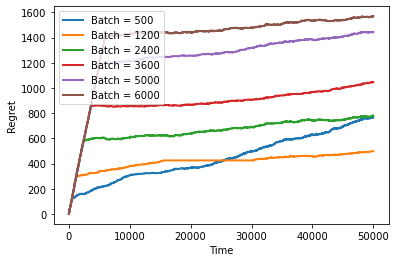

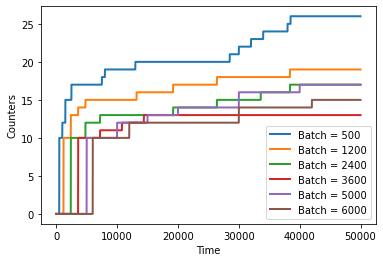

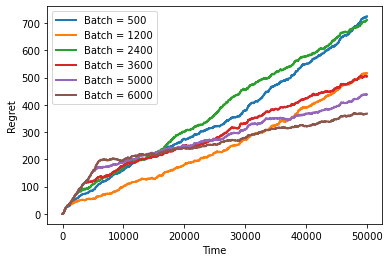

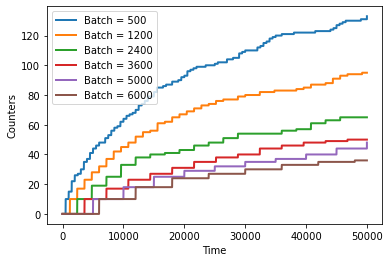

In [3]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data
ytdata = youtube(count=50_000) # YouTube Data

# Defining Parameters
cache_size = 10
L = szdata['prob'].shape[0]
batch = [500, 1200, 2400, 3600, 5000, 6000]

# assigning Optimal caches for regret calculation
optcache_sz = np.argsort(szdata['prob'])[::-1][:cache_size]
optcache_yt = np.argsort(ytdata['prob'])[::-1][:cache_size]

LFULite_sz_batch = lfulite_batch(L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'], batch=batch, name='sz')
LFULite_yt_batch = lfulite_batch(L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'], batch=batch, name='yt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


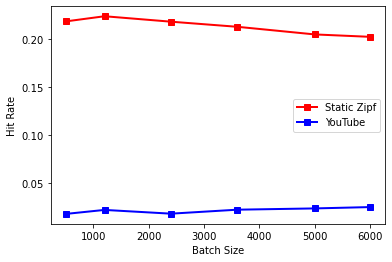

In [4]:
x = batch

plt.plot(x, LFULite_sz_batch['hitrate'], '-rs', label = 'Static Zipf', linewidth=2)
plt.plot(x, LFULite_yt_batch['hitrate'], '-bs',label = 'YouTube', linewidth=2)

plt.xlabel("Batch Size")
plt.ylabel("Hit Rate")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/Batch/llitebatchhit.eps')
plt.show()


### Window Analysis of LFULite

In [5]:
def lfulite_window(L, cache_size, optcache, req, window, name=''):
    """
    Calculates and plots the regret, no. of counters and hit rate while changing batch size 
    L: Library size
    cache_size: Size of the Cache
    optcache: Optimal Cache of length equal to cache_size
    req: Requests
    window: Batch Size for the update of the algorithm
    name: Name of the plots
    Returns plots of regret and no. of counters, and hit rate
    """
    Hit_rate = np.zeros(len(window),)
    reqshape = req.shape[0]

    x = [i for i in range(reqshape)]
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    for itr, j in enumerate(tqdm(window)):
        #Metrics Initialisation
        reg = 0
        regret = np.zeros((reqshape,))
        counters = np.zeros((reqshape,))
        hits = 0

        #Algorithm Initialisation
        alg = LFULite(L=L, cache_size=cache_size, window=j)
        currcache = random.sample(range(1,L), cache_size)
        for i in range(reqshape):
            request = req[i]    

            lhs = 1 if request in optcache else 0

            if request in currcache:
                rhs = 1
                hits += 1
            else:
                rhs = 0

            alg.update(request, i)
            currcache = alg.currcache(i)

            reg += (lhs-rhs)
            regret[i] = reg
            counters[i] = alg.counters_used()
        Hit_rate[itr] = (hits/reqshape)


        ax1.plot(x,list(regret), label = f'Window = {j}', linewidth=2)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Regret')

        ax2.plot(x,list(counters), label = f'Window = {j}', linewidth=2)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Counters')


    ax1.legend(loc= "best")
    ax1.figure.savefig(f"../plots/full_observation/single_cache/Window/llitewinr{name}.eps")

    ax2.legend(loc= "best")
    ax2.figure.savefig(f"../plots/full_observation/single_cache/Window/llitewinc{name}.eps")

    return {'hitrate':Hit_rate}

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:53<00:00, 18.86s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:54<00:00, 29.11s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaqu

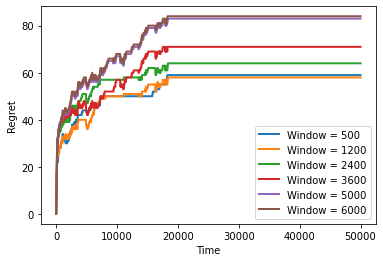

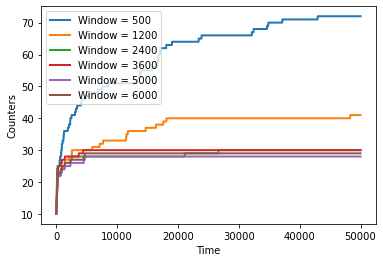

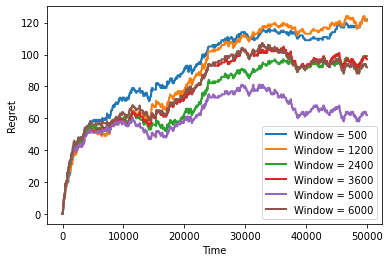

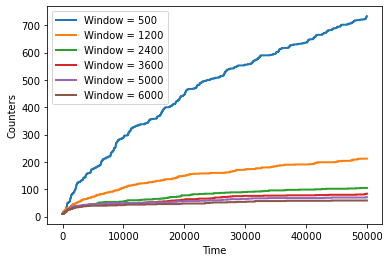

In [6]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data
ytdata = youtube(count=50_000) # YouTube Data

# Defining Parameters
cache_size = 10
L = szdata['prob'].shape[0]
window = [500, 1200, 2400, 3600, 5000, 6000]

# assigning Optimal caches for regret calculation
optcache_sz = np.argsort(szdata['prob'])[::-1][:cache_size]
optcache_yt = np.argsort(ytdata['prob'])[::-1][:cache_size]

LFULite_sz_window = lfulite_window(L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'], window=window, name='sz')
LFULite_yt_window = lfulite_window(L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'], window=window, name='yt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


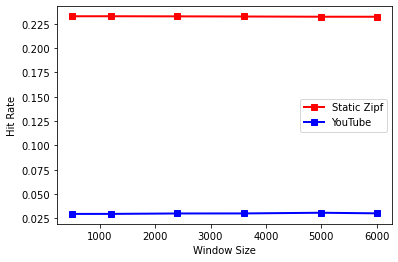

In [7]:
x = window

plt.plot(x, LFULite_sz_window['hitrate'], '-rs', label = 'Static Zipf', linewidth=2)
plt.plot(x, LFULite_yt_window['hitrate'], '-bs',label = 'YouTube', linewidth=2)

plt.xlabel("Window Size")
plt.ylabel("Hit Rate")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/Window/llitewinhit.eps')
plt.show()


## Simulations of Count-Sketch

### Regret Analysis

In [2]:
def reg_cs(l, L, cache_size, optcache, req, stepreq=None):
    """
    Calculates the regret at the each time step
    l: No. of hash functions
    L: Library size
    cache_size: Size of the Cache
    optcache: Optimal Cache of length equal to cache_size
    stepreq: None - using data other than dynamic zipf data
    req: Requests
    Returns Regret, Counter Used at each time step and final cache
    """
    reg = 0
    regret = np.zeros((req.shape[0],))
    alg = CountSketch(l=l, b=cache_size, L=L) # b = cache_size for szipf paramter = 1
    currcache = random.sample(range(1,L), cache_size)

    for i in tqdm(range(req.shape[0])):
        request = req[i]

        if stepreq != None:
            rem = i // stepreq
            optimcache = optcache[rem*cache_size:(rem+1)*cache_size]

        lhs = 1 if request in optcache else 0
        rhs = 1 if request in currcache else 0

        alg.update(request)
        currcache = alg.currcache(request)

        reg += (lhs-rhs)
        regret[i] = reg
    
    return {'regret':regret}

In [3]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data
dzdata = dzipf(count=50_000, a=1, L=1_61_085, req_step=5_000, window=500, top=50, cache_size=10) # Dynamic Zipf Data
ytdata = youtube(count=50_000) # YouTube Data

# Defining Parameters
cache_size = 10
L = szdata['prob'].shape[0]

# assigning Optimal caches for regret calculation
optcache_sz = np.argsort(szdata['prob'])[::-1][:cache_size]
optcache_yt = np.argsort(ytdata['prob'])[::-1][:cache_size]
optcache_dz = dzdata['optim_cache']

cs_sz = reg_cs(l = 6, L=L, cache_size=cache_size, optcache=optcache_sz, req=szdata['req'],)
cs_dz = reg_cs(l = 6, L=L, cache_size=cache_size, optcache=optcache_dz, req=dzdata['req'], stepreq=5000)
cs_yt = reg_cs(l = 6, L=L, cache_size=cache_size, optcache=optcache_yt, req=ytdata['req'])

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1603.44it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


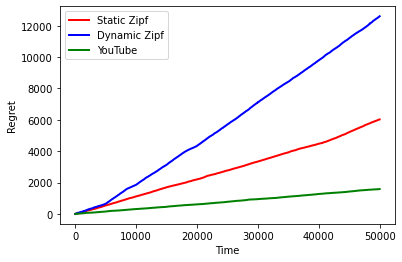

In [4]:
x = [i for i in range(szdata['req'].shape[0])]

plt.plot(x, cs_sz['regret'], 'r', label = 'Static Zipf', linewidth=2)
plt.plot(x, cs_dz['regret'], 'b',label = 'Dynamic Zipf', linewidth=2)
plt.plot(x, cs_yt['regret'], 'g',label = 'YouTube', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend(loc="best")
plt.savefig('../plots/full_observation/single_cache/csr.eps')
plt.show()

### Regret Analysis for contanst $l$- no. of hash functions

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Entered the regret computation of t = 6 and k = 10
Run: 1
Run: 2
Run: 3


 20%|████████████████▊                                                                   | 1/5 [01:27<05:49, 87.27s/it]

Entered the regret computation of t = 6 and k = 20
Run: 1
Run: 2
Run: 3


 40%|█████████████████████████████████▏                                                 | 2/5 [03:47<05:09, 103.20s/it]

Entered the regret computation of t = 6 and k = 40
Run: 1
Run: 2
Run: 3


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [08:02<04:57, 148.84s/it]

Entered the regret computation of t = 6 and k = 60
Run: 1
Run: 2
Run: 3


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [14:05<03:33, 213.04s/it]

Entered the regret computation of t = 6 and k = 80
Run: 1
Run: 2
Run: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [21:09<00:00, 253.87s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


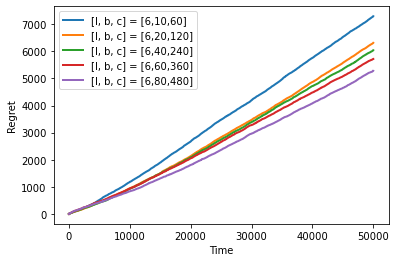

In [4]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data

# Defining Parameters
L = szdata['prob'].shape[0]
req = szdata['req']
x = [i for i in range(req.shape[0])]

for i in [6]:  # l
    for j in tqdm([10, 20, 40, 60, 80]):  #b or cache_size
          
        print(f'Entered the regret computation of t = {i} and k = {j}')
        regret = np.zeros((req.shape[0],))
        for steps in range(3):
            reg = 0
            optcache = np.argsort(szdata['prob'])[::-1][:j]

            
            alg = CountSketch(l=i, b=j, L=L)
            currcache = random.sample(range(1,L),j)

            print(f'Run: {steps + 1}')
            for k in range(req.shape[0]):
                request = req[k]

                lhs = 1 if request in optcache else 0
                rhs = 1 if request in currcache else 0

                alg.update(request)
                currcache = alg.currcache(request)

                reg += (lhs-rhs)
                regret[k] += reg
        regret = regret/3
        
       
        plt.plot(x,list(regret), label = f'[l, b, c] = [{i},{j},{i*j}]', linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Regret')

plt.legend(loc = "best")
plt.savefig("../plots/full_observation/single_cache/csconstl.eps")
plt.show() 

### Regret Analysis for contanst $b$ - no. of buckets or cache_size

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Entered the regret computation of t = 6 and k = 10
Run: 1
Run: 2
Run: 3


 20%|████████████████▊                                                                   | 1/5 [01:21<05:26, 81.59s/it]

Entered the regret computation of t = 12 and k = 10
Run: 1
Run: 2
Run: 3


 40%|█████████████████████████████████▌                                                  | 2/5 [02:57<04:18, 86.02s/it]

Entered the regret computation of t = 24 and k = 10
Run: 1
Run: 2
Run: 3


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [05:03<03:15, 97.88s/it]

Entered the regret computation of t = 48 and k = 10
Run: 1
Run: 2
Run: 3


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:23<02:08, 128.66s/it]

Entered the regret computation of t = 72 and k = 10
Run: 1
Run: 2
Run: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:46<00:00, 153.36s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


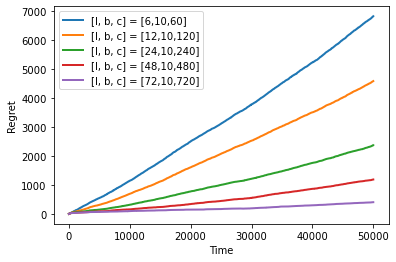

In [5]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=1_61_085) # Static Zipf Data

# Defining Parameters
L = szdata['prob'].shape[0]
req = szdata['req']
x = [i for i in range(req.shape[0])]

for i in tqdm([6, 12, 24, 48, 72]):  # l
    for j in [10]:  #b or cache_size
          
        print(f'Entered the regret computation of t = {i} and k = {j}')
        regret = np.zeros((req.shape[0],))
        for steps in range(3):
            reg = 0
            optcache = np.argsort(szdata['prob'])[::-1][:j]

            alg = CountSketch(l=i, b=j, L=L)
            currcache = random.sample(range(1,L),j)

            print(f'Run: {steps + 1}')
            for k in range(req.shape[0]):
                request = req[k]

                lhs = 1 if request in optcache else 0
                rhs = 1 if request in currcache else 0

                alg.update(request)
                currcache = alg.currcache(request)

                reg += (lhs-rhs)
                regret[k] += reg
        regret = regret/3
        
       
        plt.plot(x,list(regret), label = f'[l, b, c] = [{i},{j},{i*j}]', linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Regret')

plt.legend(loc = "best")
plt.savefig("../plots/full_observation/single_cache/csconstb.eps")
plt.show() 